In [1]:
!hostname
!pwd

freeman-titanxp-5.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src


In [2]:
# This is autoreload module code using jupyter magic
%load_ext autoreload
%autoreload 2

In [82]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import os
from tqdm.auto import tqdm
import glob
import matplotlib

from einops import rearrange, repeat

In [83]:

def plot_curve_lines(x, y, c="r", **kwargs):  # x.shape=(t, ), y.shape = (n, t)
    c = matplotlib.colors.to_rgba(c)
    plt.plot(x, y.mean(axis=0), c=c, **kwargs)
    c = [c[0], c[1], c[2], .1]
    plt.plot(x, y.T, c=c)

def plot_curve_err(x, y, c="r", **kwargs):  # x.shape=(t, ), y.shape = (n, t)
    c = matplotlib.colors.to_rgba(c)
    mean, std = y.mean(axis=0), y.std(axis=0)
    err = std/np.sqrt(y.shape[0])
    plt.plot(x, mean, c=c, **kwargs)
    c = [c[0], c[1], c[2], .1]
    plt.fill_between(x, mean-err, mean+err, color=c)


../data/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(8, 1000)


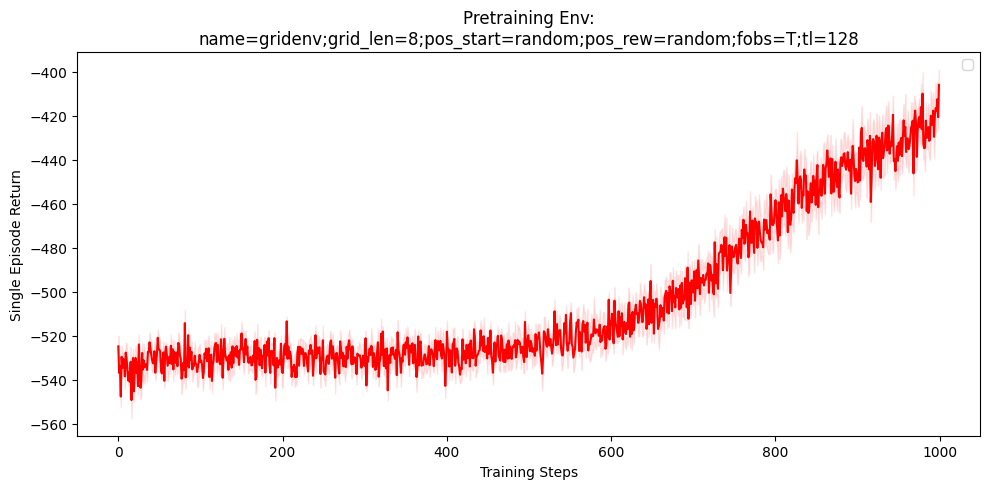

In [94]:
def viz_training(load_dir):
    print(load_dir)
    with open(f"{load_dir}/config.json", "r") as f:
        config = json.load(f)
    with open(f"{load_dir}/rew.pkl", "rb") as f:
        rew = np.asarray(pickle.load(f)) # (s, n, t, e)
    rets = rew.sum(axis=-2).mean(axis=-1)
    print(rets.shape)
    
    plt.figure(figsize=(10, 5))
    # plot_curve_lines(np.arange(rets.shape[-1]), rets, c="r")
    plot_curve_err(np.arange(rets.shape[-1]), rets, c="r")
    
    plt.title(f"Pretraining Env:\n{config['env_id']}")
    plt.ylabel('Single Episode Return')
    plt.xlabel('Training Steps')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{args.save_dir}/plot_pretrain.png')
    # plt.close()

    
viz_training("../data/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128")


../data/transfer/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128


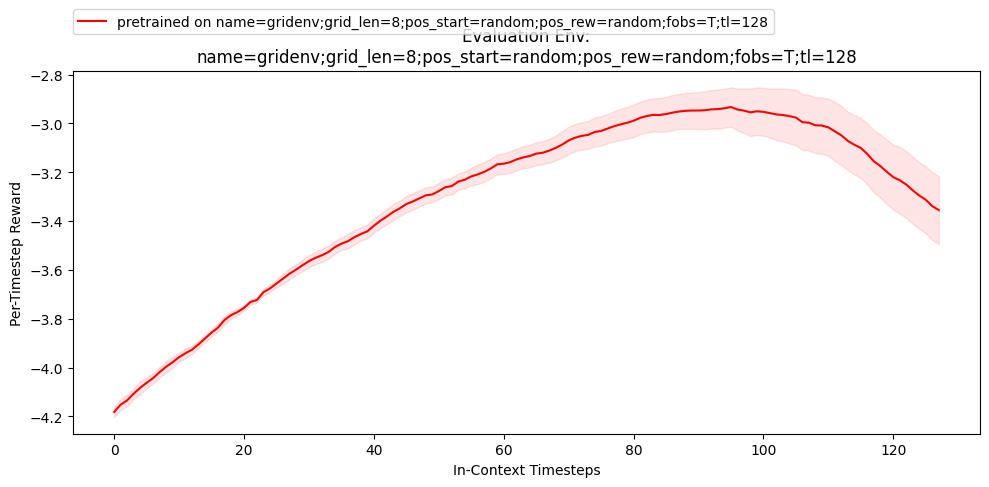

In [95]:

def viz_eval(load_dir):
    print(load_dir)
    eval_dirs = sorted([path for path in glob.glob(f"{load_dir}/*") if os.path.isdir(path)])
    plt.figure(figsize=(10, 5))
    for i, eval_dir in enumerate(eval_dirs):
        with open(f"{eval_dir}/config.json", "r") as f:
            config = json.load(f)
        with open(f"{config['load_dir']}/config.json", "r") as f:
            config_pre = json.load(f)
        env, env_pre = config['env_id'], config_pre['env_id']
        
        with open(f'{eval_dir}/rew.pkl', 'rb') as f:
            rew = np.asarray(pickle.load(f)) # (s, n, t, e)
        rew = rew.mean(axis=(1, 3))
        plot_curve_err(np.arange(rew.shape[-1]), rew, c="r", label=f"pretrained on {env_pre}")
        
        # for i, env_pre in enumerate(sorted(os.listdir(f'../data/transfer/{env_trans}'))):
        #     with open(f'../data/transfer/{env_trans}/{env_pre}/rews_trained.pkl', 'rb') as f:
        #         rews_trained = np.asarray(pickle.load(f))
        #     plot_single(rews_trained, label=f"pretrained on {env_pre}", c=matplotlib.colors.to_rgba(colors[i]))
        # with open(f'../data/transfer/{env_trans}/{env_pre}/rews_init.pkl', 'rb') as f:
        #     rews_init = np.asarray(pickle.load(f))
        # plot_single(rews_init, label='init', c=matplotlib.colors.to_rgba('black'))
    plt.title(f'Evaluation Env:\n{env}')
    plt.ylabel('Per-Timestep Reward')
    plt.xlabel('In-Context Timesteps')
    plt.legend(loc=(0., 1.1))
    plt.tight_layout()
    # plt.savefig(f'{args.save_dir}/plot_eval.png')

viz_eval("../data/transfer/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128")

In [10]:
!ls "../data/transfer/name=gridenv;grid_len=8;fobs=T;rpo=64;tl=128/name=gridenv;grid_len=8;fobs=T;rpo=64;tl=128"

buffers.pkl  config.json  rew.pkl


In [96]:
with open("../data/transfer/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128/buffers.pkl", "rb") as f:
    buffers = jax.tree_map(lambda x: jnp.asarray(x), pickle.load(f))

In [97]:
buffers[0].keys()

dict_keys(['act', 'done', 'env_state', 'info', 'log_prob', 'logits', 'obs', 'rew', 'val'])

In [90]:
d = np.stack([b['info']['goal_dist'] for b in buffers], axis=1)
d.shape

(8, 10, 128, 128)

(0.0, 9.0)

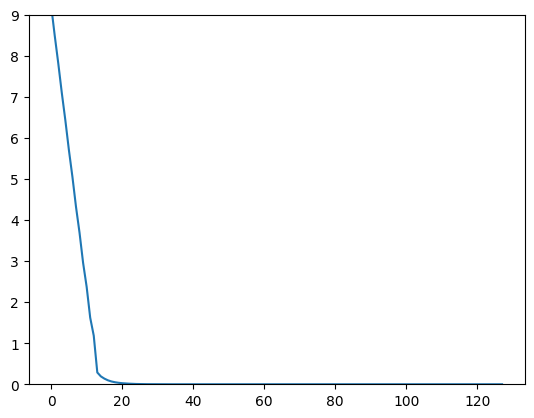

In [93]:
plt.plot(d.mean(axis=(0, 1, 3)))
plt.ylim(0, 9)